# Fisher's Linear Discriminant Analysis (LDA)

Quick example notebook on Fisher's LDA to complement the corresponding [Python script](../../scripts/lda_example.py).

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.set_printoptions(suppress=True)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Let's first consider a two-class dataset where each class-conditional distribution is a multivariate Gaussian, $\mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)$ and $\mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$. The following parameters are considered for the Gaussian class-conditionals:

\begin{equation*}
    \boldsymbol{\mu}_0=\begin{bmatrix} 5\\1 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_0=\begin{bmatrix}1 & -1.5 \\-1.5 & 3 \end{bmatrix}, ~~~
    \boldsymbol{\mu}_1=\begin{bmatrix} -1\\-3 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_1=\begin{bmatrix}5 & -0.5 \\-0.5 & 10 \end{bmatrix}. ~~~
\end{equation*}

We will draw $N_0=100$ and $N_1=130$ samples from the respective class-conditional pdfs to form our dataset:

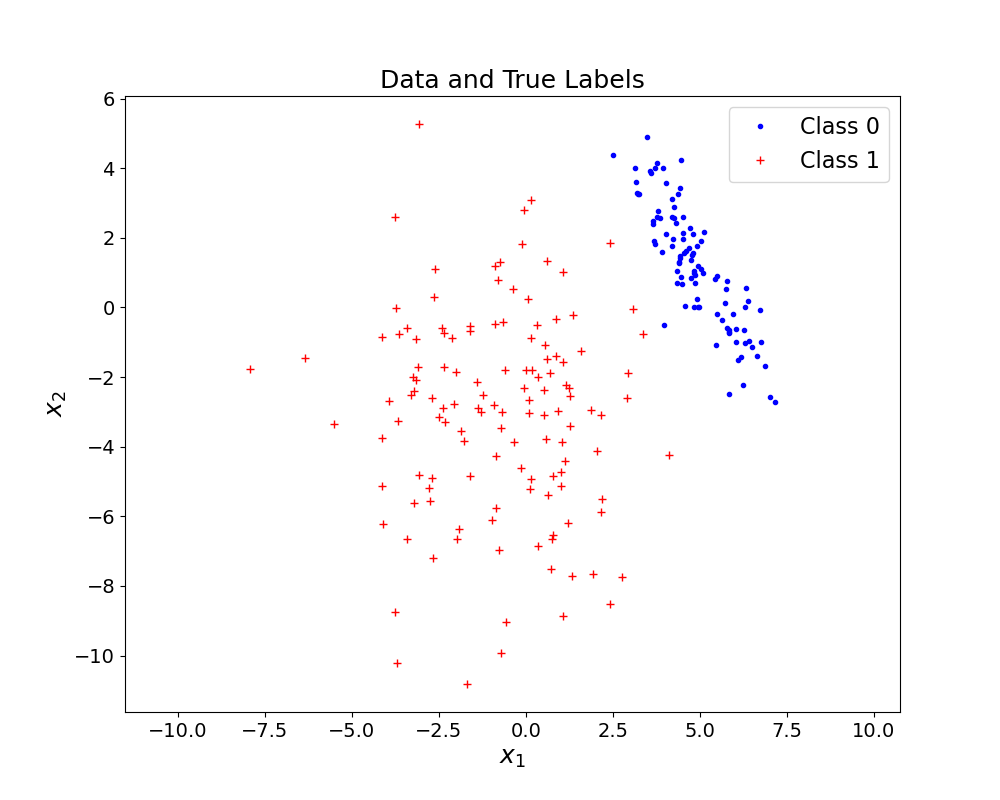

In [2]:
N0 = 100
N1 = 130

mu = np.array([[5, 1],
               [-1, -3]])  # Gaussian distributions means
Sigma = np.array([[[1, -1.5],
                   [-1.5, 3]],
                  [[5, -0.5],
                   [-0.5, 10]]])  # Gaussian distributions covariance matrices

# Draw random variable samples and assign labels
X0 = multivariate_normal(mean=mu[0], cov=Sigma[0]).rvs(N0)
X1 = multivariate_normal(mean=mu[1], cov=Sigma[1]).rvs(N1)
X = np.concatenate((X0, X1))
labels = np.concatenate((np.zeros(N0), np.ones(N1)))

plt.figure(figsize=(10, 8))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'b.', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'r+', label="Class 1");

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.legend()
plt.axis('equal')
plt.show()

Now we introduce a linear classification model that can be viewed in terms of dimensionality reduction, namely <b>Fisher's LDA</b>. The key idea here is to project data to a low dimensional space that preserves structure useful for classification.

For our two-class problem, the input data is two-dimensional $\mathbf{x} \in \mathbb{R}^2$, however we can generally reduce any arbitrary $n$-dimensional input to a lower $k$-dimensional space: $\mathbf{x} \in \mathbb{R}^n \rightarrow \mathbf{z} \in \mathbb{R}^{k}$ where $k < n$.

In the case where we project inputs $\mathbf{x}$ onto a line with direction $\mathbf{w}$, a linear classifier $f(\cdot)$ would take on the form:

$$f(\mathbf{w}^\intercal\mathbf{x}) =
    \begin{cases}
        1 & \text{if} \; \mathbf{w}^\intercal\mathbf{x} > \gamma \\
        0 & \text{otherwise}
    \end{cases},$$
    
where $\gamma$ is the threshold that separates classes in the projected low-dimensional space.

Under this setting, Fisher's LDA aims to find a projection to a line that will <i>maximize separability</i> between the classes.

## Maximizing Separability

So we want projections of samples from different classes to have minimal overlap or maximum separability. Then the first step might be to define this measure. Consider the class-specific mean vectors:

$$ \boldsymbol{\mu}_k = \displaystyle \frac{1}{N_k} \sum_{i : y^{(i)}= k} \mathbf{x}^{(i)} \; \; \text{for} \; k=0, 1,$$

where $y^{(i)}$ is the label for some arbitrary dataset sample $\mathbf{x}^{(i)}$. We can then define the mean projections as $ m_k = \mathbf{w}^\intercal \boldsymbol{\mu}_k$.

Now we could define the distance between projected means, or <b>between-class variance</b>, as a measure of separability: $(m_1 - m_0)^2$. However, this would not consider the spread between projected classes, which could result in class overlapping. As a result, we also want to ensure that the clusters are "tight" to reduce overlap between the two class distributions. This was Fisher's idea, which requires us to incorporate <b>within-class variance</b> into our definition of separability.

For each projected point $z^{(i)} = \mathbf{w}^\intercal\mathbf{x}^{(i)}$, class variance is proportional to:

\begin{align*}
s_k^2 & = \sum_{i : y^{(i)}= k} (z^{(i)} - m_k)^2 = \sum_{i : y^{(i)}= k} (\mathbf{w}^\intercal\mathbf{x}^{(i)} - \mathbf{w}^\intercal\boldsymbol{\mu}_k)^2 \\
& = \sum_{i : y^{(i)}= k} \mathbf{w}^\intercal(\mathbf{x}^{(i)} - \boldsymbol{\mu}_k)(\mathbf{x}^{(i)} - \boldsymbol{\mu}_k)^\intercal \mathbf{w} =\mathbf{w}^\intercal \mathbf{S}_k  \mathbf{w} \; \; \text{for} \; k=0, 1,
\end{align*}

where $\mathbf{S}_k$ is the scatter matrix for class $k$. Smaller scatter implies that the projected samples are tightly clustered around the projected mean.

Therefore, the objective function $\mathcal{L}(\mathbf{w})$ for Fisher's LDA is to select a projection vector $\mathbf{w}_\text{LDA}$ that maximizes between-class variance while simultaneously minimizing within-class variance:

$$ \mathbf{w}_\text{LDA} = \max_\mathbf{w} \mathcal{L}(\mathbf{w}) = \max_\mathbf{w} \frac{(m_1 - m_0)^2}{s_0^2 + s_1^2}.$$

To find a solution to this optimization problem, let's express this objective function in terms of $\mathbf{w}$:

\begin{align*}
\mathcal{L}(\mathbf{w}) & = \frac{(m_1 - m_0)^2}{s_0^2 + s_1^2} = \frac{(\mathbf{w}^\intercal \boldsymbol{\mu}_1 - \mathbf{w}^\intercal \boldsymbol{\mu}_0)^2}{\mathbf{w}^\intercal \mathbf{S}_0  \mathbf{w} + \mathbf{w}^\intercal \mathbf{S}_1  \mathbf{w}} \\
& = \frac{\mathbf{w}^\intercal (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0)(\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0)^\intercal \mathbf{w}}{\mathbf{w}^\intercal (\mathbf{S}_0 + \mathbf{S}_1) \mathbf{w}} = \frac{\mathbf{w}^\intercal \mathbf{S}_B \mathbf{w}}{\mathbf{w}^\intercal \mathbf{S}_W \mathbf{w}},
\end{align*}

with $\mathbf{S}_B$ and $\mathbf{S}_W$ acting as the between- and within-class scatter matrices, respectively.

Fisher's <i>criterion</i> is thereby formulated as:
$$ \mathbf{w}_\text{LDA} = \max_\mathbf{w} \mathcal{L}(\mathbf{w}) = \max_\mathbf{w} \frac{\mathbf{w}^\intercal \mathbf{S}_B \mathbf{w}}{\mathbf{w}^\intercal \mathbf{S}_W \mathbf{w}}.$$

To solve this optimization problem, we require the derivative (using the [quotient rule](https://en.wikipedia.org/wiki/Quotient_rule)) of the objective function:

\begin{equation*}
\frac{\delta \mathcal{L}}{\delta \mathbf{w}} = \frac{2 \mathbf{S}_B \mathbf{w} (\mathbf{w}^\intercal \mathbf{S}_W \mathbf{w}) - 2 \mathbf{S}_W \mathbf{w} (\mathbf{w}^\intercal \mathbf{S}_B \mathbf{w})}{(\mathbf{w}^\intercal \mathbf{S}_W \mathbf{w})^2} = 0
\end{equation*}

We can rearrange this to obtain:

\begin{align*}
\mathbf{S}_B \mathbf{w} = 
\Bigg( \frac{\mathbf{w}^\intercal \mathbf{S}_B \mathbf{w}}{\mathbf{w}^\intercal \mathbf{S}_W \mathbf{w}} \Bigg) \mathbf{S}_W \mathbf{w}
\end{align*}

Which as a [generalized eigenvalue problem](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Generalized_eigenvalue_problem) is:

$$\mathbf{S}_B \mathbf{w} = \lambda \mathbf{S}_W \mathbf{w},$$

or if $\mathbf{S}^{-1}_W$ exists, then as a regular eigenvalue problem:

$$\mathbf{S}^{-1}_W \mathbf{S}_B \mathbf{w} = \lambda  \mathbf{w}.$$
 
As we only care about directionality and can ignore scale (also explaining why there's no need for a $||\mathbf{w}||=1$ constraint on the optimization problem), then the optimal $\mathbf{w}^*$, or Fisher's solution vector $\mathbf{w}_\text{LDA}$, is the eigenvector of $\mathbf{S}^{-1}_W \mathbf{S}_B$ with the largest eigenvalue $\lambda$.

The below routine is the code for this method:

In [3]:
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    Note: you can generalize this implementation to multiple classes by finding a
    projection matrix W (rather than vector) that reduces dimensionality n inputs
    to a multidimensional projection z=W'*x (e.g. z of dimension C-1). Now we have
    a crude but quick way of achieving class-separability-preserving linear dimensionality
    reduction using the Fisher LDA objective as a measure of class separability.

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        labels: Class labels per sample received as an [N, 1] column.
        C: Number classes, explicitly clarifying that we're doing binary classification here.

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
        mu: Class-specific mean vectors [n, 1].
    """

    # Estimate mean vectors and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]
    # Extract corresponding sorted eigenvectors
    U = U[:, idx]
    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z

Applying Fisher's LDA to our dataset and then projecting the data onto the vector $\mathbf{w}_\text{LDA}$, we find:

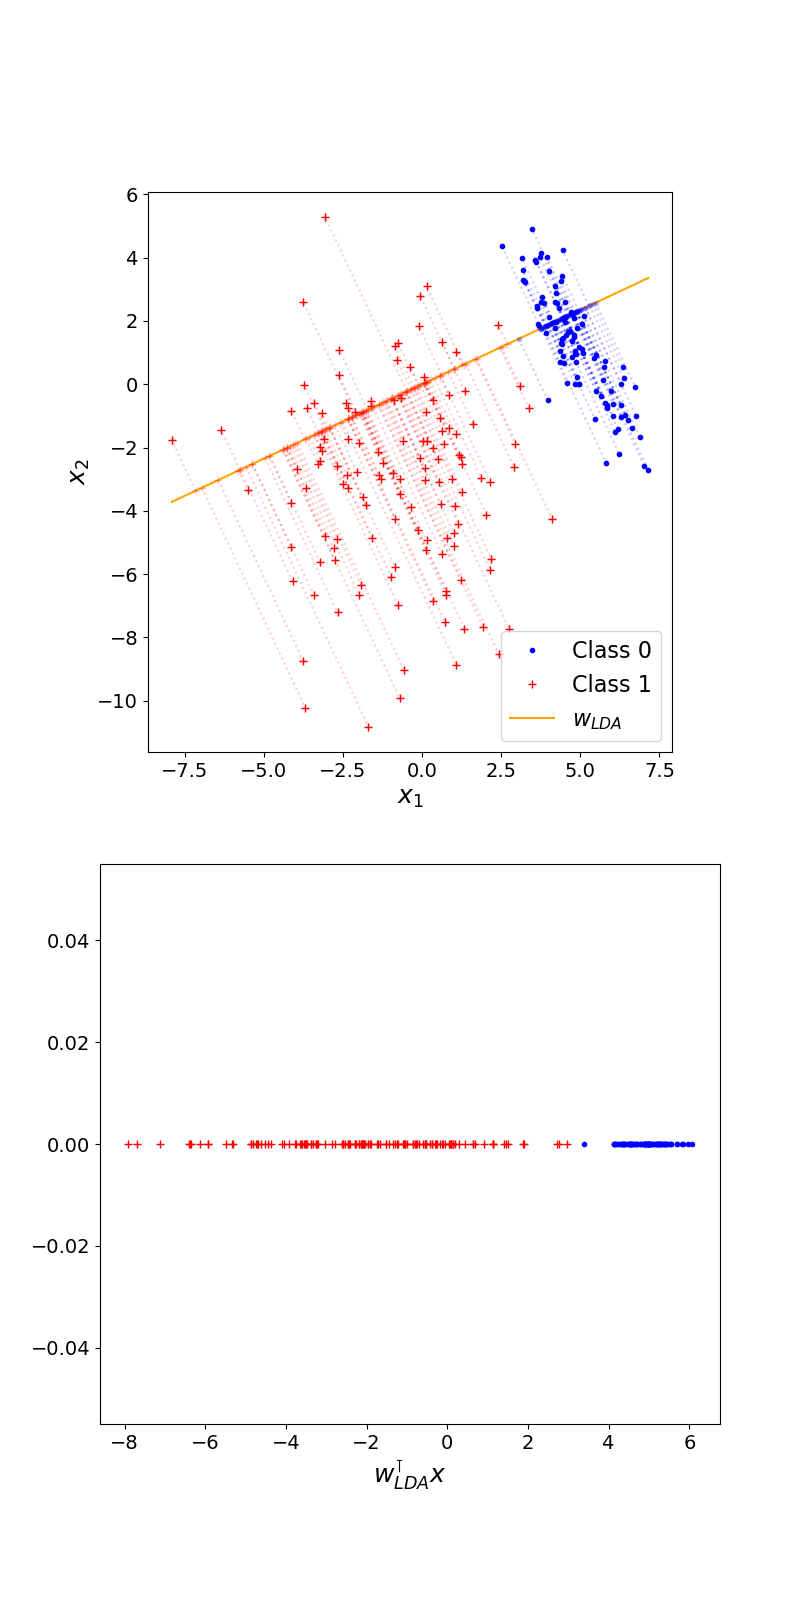

In [4]:
w_lda, z = perform_lda(X, labels)

# Work out slope of Fisher's direction vector
slope = w_lda[1] / w_lda[0]
# Get bounds of x-axis for dataset to draw line
x_bounds = np.array([np.min(X[:, 0]), np.max(X[:, 0])])

fig = plt.figure(figsize=(8, 16))

x0 = X[labels == 0]
x1 = X[labels == 1]
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(x0[:, 0], x0[:, 1], 'b.', x1[:, 0], x1[:, 1], 'r+')
# Draw Fisher's discriminant line in direction w_lda to span x_bounds
ax1.plot(x_bounds, slope * x_bounds, c='orange')

# Reconstruct 2D coordinates from 1D projections, with reshaping to treat vectors as matrices
z_rec = z.reshape(-1, 1).dot(w_lda.reshape(-1, 1).T)

ax1.plot([z_rec[labels == 0, 0], X[labels == 0, 0]], [z_rec[labels == 0, 1], X[labels == 0, 1]], 'b.:', alpha=0.2)
ax1.plot([z_rec[labels == 1, 0], X[labels == 1, 0]], [z_rec[labels == 1, 1], X[labels == 1, 1]], 'r+:', alpha=0.2)

ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.legend(["Class 0", "Class 1", r"$w_{LDA}$"])
ax1.set_aspect('equal')

ax2 = fig.add_subplot(2, 1, 2)
z0 = z[labels == 0]
z1 = z[labels == 1]
ax2.plot(z0, np.zeros(len(z0)), 'b.', z1, np.zeros(len(z1)), 'r+')
ax2.set_xlabel(r"$w_{LDA}^\intercal x$")

# If using sklearn instead, where midpoint between means is not passed through:
# lda = LinearDiscriminantAnalysis()
# X_fit = lda.fit(X, labels)  # Is a fitted estimator, not actual data to project
# z = lda.transform(X)

# c, w_sklearn = lda.intercept_, X_fit.coef_[0]
# slope = w_sklearn[1] / w_sklearn[0]

plt.show()

To then classify samples, you can set the decision threshold $\gamma$ to be one that say minimizes the probability of error $\text{Pr}(\text{error};\gamma)=p(D=1\,|\,L=0;\gamma)p(L=0)+p(D=0\,|\,L=1;\gamma)p(L=1)$ for decisions $D$ and labels $L$. An ROC curve is informative in marking this operating point.

## Notes

Please note the following about Fisher's LDA:
- We can extend Fisher's LDA to cases where $C > 2$, but we instead derive a projection matrix $\mathbf{W}$ that consists of $C-1$ projections $\mathbf{z}$ 
- There is a restriction on how dimensionality is reduced using Fisher's LDA, where the data can be at most reduced to $k = C - 1$ dimensional space, irrespective of the order $n$ (due to rank of $\mathbf{S}_B$ being $C-1$)
- $\mathcal{L}(\mathbf{w})$ is always $0$ when $\boldsymbol{\mu}_0 = \boldsymbol{\mu}_1$, meaning Fisher's LDA fails to discriminate classes when the difference is entirely in the class variance 